In [66]:
ls_columns_output = [
#     '№ партии',
#     '№ плавки',
    'марка стали',
    'диаметр',
    'толщина стенки',
    'Гр. прочн.',
    '1 зона по ВТР закалка',
    '2 зона по ВТР закалка',
    '3 зона по ВТР закалка',
    'шаг балок закалочная печь, сек',
    'Скорость прохождения трубы через спрейер, м/с', 
    't˚ C трубы после спреера',
    '1 зона ВТР и уставка отпуск', 
    '2 зона ВТР и уставка отпуск', 
    '3 зона ВТР и уставка отпуск',
    '4 зона ВТР и уставка отпуск',
    '5 зона ВТР и уставка отпуск',
    'шаг балок отпускная печь, сек',
    'C',
    'Mn',
    'Si',
    'P',
    'S',
    'Cr',
    'Ni',
    'Cu',
    'Al',
    'V',
    'Ti',
    'Nb',
    'Mo',
    'N',
    'B',
    'C-coef',
    'Параметр закалка',
    'Параметр отпуск',
    'Параметр отпуск новый V',
    'Величина зерна',
    'Тип предела текучести (1186)',
#     'Дата термообработки',
    'ICD',
#     'Примечание',
    'длина трубы'
    ]

In [52]:
target = 't˚ C трубы после спреера'

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, median_absolute_error, mean_absolute_error
from datetime import datetime

In [36]:
import import_ipynb
from my_libs.create_prepared_data import create_prepared_data
from my_libs.calc_features import *

In [69]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate, train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn import model_selection
import time
from sklearn.neural_network import MLPRegressor
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
from sklearn.preprocessing import LabelEncoder
from time import time
from datetime import datetime
import json
from my_libs.save_lib import save_RF_model
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

In [110]:
df = pd.read_csv('prepared_to_saw_gp.csv',low_memory=False)

In [111]:
bath = df[~df['время выдержки в закалочной ванне, сек.'].isnull()].copy()
df_ = df[df['время выдержки в закалочной ванне, сек.'].isnull()].copy()

In [112]:
bath.shape, df.shape

((1100, 201), (24503, 201))

In [113]:
def bath2spr(df):
    L = 8.4
    df['Скорость прохождения трубы через спрейер, м/с'] = L/df['время выдержки в закалочной ванне, сек.']
    df['t˚ C трубы после спреера'] = df['t˚ C трубы после ванны']
    return df

In [114]:
bath = bath2spr(bath)

In [115]:
df = pd.concat([df_, bath])
df.reset_index(inplace=True, drop=True)

In [116]:
df = len_pipe(df)

C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\calc_features.ipynb:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  "def mean_chem(df):\n",
C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\calc_features.ipynb:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  "                f.write('Строка ' + str(i+1) + ' удалена из-за пустых столбцов: ' + str(arr_col) + '\\n')\n",
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [117]:
df = mean_chem(df)

In [119]:
df = calc_all_features(df)

C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\calc_features.ipynb:117: RuntimeWarning: divide by zero encountered in log10
  "\n",


In [120]:
df['Дата термообработки'] = df['Дата термообработки'].apply(lambda x: str(x).replace(' 00:00:00', ''))
df['Дата термообработки'] = df['Дата термообработки'].apply(lambda x: str(x).replace('-', '.'))

tmp = []
for x in df['Дата термообработки']:
    try:
        tmp.append(datetime.strptime(x, "%d.%m.%Y"))
    except ValueError:
        tmp.append(datetime.strptime(x, "%Y.%m.%d"))
df['Дата термообработки'] = tmp

In [121]:
valid = df[df['Дата термообработки'].apply(lambda x:x.year)>2017].copy()
df = df[df['Дата термообработки'].apply(lambda x:x.year)<2018].copy()

In [122]:
df.shape,valid.shape 

((23009, 202), (1494, 202))

In [123]:
ls_train = ls_columns_output.copy()
ls_train.remove(target)

In [137]:
for s in ls_to_del:
    ls_train.remove(s) 

In [138]:
df_ = df[ls_train+[target]].dropna()
valid_ = valid[ls_train+[target]].dropna()


X = df_[ls_train].copy()
y = df_[target].copy()
X_valid = valid_[ls_train].copy()
y_valid = valid_[target].copy()

In [139]:
def print_and_return_score(x, y, est):
    y_pred = est.predict(x)
    scr = est.score(x, y)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    corr = []
    corr = np.corrcoef(y.T, y_pred)
        
    print('Score: ', round(scr, 2))
    print('R^2: ', round(r2, 2))
    print('MAE: ', round(mae, 2))
    print('MSE: ', round(mse, 2))
    print('Correlation: ', round(corr[0][1], 2))
    return [scr, mae, mse, corr[0][1]]

In [140]:
label = LabelEncoder() 

X['марка стали'] = label.fit_transform(X['марка стали'])
X_valid['марка стали'] = label.fit_transform(X_valid['марка стали'])

X['Гр. прочн.'] = label.fit_transform(X['Гр. прочн.'])
X_valid['Гр.прочн.'] = label.fit_transform(X_valid['Гр. прочн.'])

In [141]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3)

rfc = RandomForestRegressor(max_features = 9, max_depth = 15, min_samples_leaf = 2, n_estimators=100, criterion='mse')
rfc.fit(X_train, y_train)

scr, mae, mse, corr1  = print_and_return_score(X_test, y_test, rfc)

Score:  0.94
R^2:  0.94
MAE:  1.93
MSE:  18.05
Correlation:  0.97


In [134]:
print('Score: ', round(scr, 2))
print('MAE: ', round(mae, 2))
print('MSE: ', round(mse, 2))
print('Correlation: ', round(corr1, 2))

Score:  0.93
MAE:  1.97
MSE:  21.02
Correlation:  0.97


In [135]:
val = rfc.feature_importances_
lab = ls_train
dict_feat_import = dict(zip(lab, val))
ls_to_del = []
for feat, imp in zip(lab, val):
    print(feat, '  ', imp.round(2))
    if imp.round(2) < 0.01:
        ls_to_del.append(feat)

марка стали    0.01
диаметр    0.04
толщина стенки    0.04
Гр. прочн.    0.01
1 зона по ВТР закалка    0.03
2 зона по ВТР закалка    0.02
3 зона по ВТР закалка    0.03
шаг балок закалочная печь, сек    0.08
Скорость прохождения трубы через спрейер, м/с    0.15
1 зона ВТР и уставка отпуск    0.02
2 зона ВТР и уставка отпуск    0.02
3 зона ВТР и уставка отпуск    0.01
4 зона ВТР и уставка отпуск    0.04
5 зона ВТР и уставка отпуск    0.02
шаг балок отпускная печь, сек    0.07
C    0.01
Mn    0.01
Si    0.01
P    0.0
S    0.0
Cr    0.01
Ni    0.01
Cu    0.01
Al    0.0
V    0.01
Ti    0.01
Nb    0.02
Mo    0.01
N    0.01
B    0.01
C-coef    0.01
Параметр закалка    0.08
Параметр отпуск    0.02
Параметр отпуск новый V    0.04
Величина зерна    0.01
Тип предела текучести (1186)    0.0
ICD    0.02
длина трубы    0.1


In [136]:
ls_to_del

['P', 'S', 'Al', 'Тип предела текучести (1186)']

## GridSearchCV

In [142]:
param_grid = {
    'max_depth': range(6, 18, 2),
    'max_features': range(6, 18, 2),
    'min_samples_leaf': range(1, 5),
    'n_estimators': range(50, 300, 50)
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_absolute_error')

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [144]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 18.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(6, 18, 2), 'max_features': range(6, 18, 2), 'min_samples_leaf': range(1, 5), 'n_estimators': range(50, 300, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [245]:
grid_search.best_params_

{'max_depth': 16,
 'max_features': 16,
 'min_samples_leaf': 2,
 'n_estimators': 250}

In [246]:
scr, mae, mse, corr, y_pred = print_and_return_score(X_test, y_test, grid_search)

Score:  -1.97
R^2:  0.9
MAE:  1.97
MSE:  8.04
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94


In [247]:
y_predict = grid_search.predict(X_test)

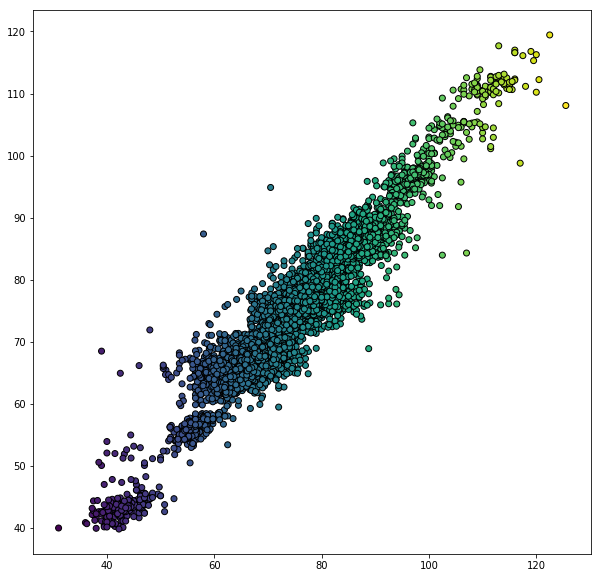

In [248]:
plt.subplots(figsize=(10,10))
plt.scatter(y_test, y_predict, marker='o', c=y_test, edgecolors='black', cmap='viridis')
# plt.colorbar()
plt.show()

In [249]:
kfold = model_selection.KFold(n_splits=5, shuffle=True)
scores = []
for train, test in kfold.split(X, y):
    x_train, y_train = X.iloc[train], y.iloc[train]
    x_test, y_test = X.iloc[test], y.iloc[test]
    grf = grid_search.best_estimator_
    grf.fit(x_train, y_train)

    scores.append(print_and_return_score(X_valid, y_valid, grf))

Score:  0.9
R^2:  0.9
MAE:  2.73
MSE:  13.67
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94
Score:  0.9
R^2:  0.9
MAE:  2.7
MSE:  13.36
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94
Score:  0.89
R^2:  0.9
MAE:  2.77
MSE:  14.3
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94
Score:  0.89
R^2:  0.9
MAE:  2.78
MSE:  14.19
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94
Score:  0.9
R^2:  0.9
MAE:  2.7
MSE:  13.35
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.94


In [250]:
for i in range(5):
    tmp = []
    for j in range(5):
        tmp.append(scores[j][i])
    print(round(np.mean(tmp), 2))

0.9
2.74
13.78
0.96
0.94
